# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)

In [52]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021_GROUP-69_group-sections.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1315


In [26]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib as plt
from collections import Counter
import matplotlib.pyplot as plt
import bisect
import random
import re

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import plot_roc_curve, precision_recall_fscore_support, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import datetime as dt
import time
import pytz

In [27]:
# data is pickled, faster than a CSV
df = pd.read_pickle("~/Documents/Delft/CDA 2021/Lab 1/data_lab_1.pkl")
df

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,482729,2015-11-03 18:57:01,SE,visadebit,453903.0,48100.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:21:58,SwedenAccount,email135821,ip125573,card83162
290378,482731,2015-11-03 08:12:14,SE,mcdebit,554501.0,195000.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:31:24,SwedenAccount,email259702,ip202029,card131519
290379,482732,2015-11-03 08:12:14,SE,visadebit,453903.0,52500.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:41:40,SwedenAccount,email32927,ip229869,card142173
290380,482733,2015-11-03 18:56:44,SE,mcdebit,554501.0,87700.0,SEK,SE,Ecommerce,Settled,True,1,2015-10-31 23:50:07,SwedenAccount,email97400,ip200721,card141579


In [28]:
# simple_journal seems to be the attribute that includes transaction type. How many chargebacks (fraud) exist in the set?
print(len(df.simple_journal[df.simple_journal == 'Chargeback']))
print('Total ratio of chargebacks to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Chargeback']) / len(df.index)))
print('Total ratio of refused transactions to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Refused']) / len(df.index)))
print('Total ratio of legitimate transactions to total transactions: ' + str(len(df.simple_journal[df.simple_journal == 'Settled']) / len(df.index)))

345
Total ratio of chargebacks to total transactions: 0.0011880901708783602
Total ratio of refused transactions to total transactions: 0.1837097340744261
Total ratio of legitimate transactions to total transactions: 0.8151021757546956


## Group Number: 69

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme instructions:

Install the following packages:

`pip3 install imblearn` for over/undersampling (to compare their SMOTE implementation with ours)

`pip3 install shap` for classifier interpretation in section 4


In [32]:
# Attribute List:
# issuercountrycode: country where the card was issued
# txvariantcode: the card type that was used (subbrand of visa or master card)
# bin: card issuer identifier
# amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
# shoppercountrycode: IP address country
# shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription, POS if the card was used at Point of Sale
# simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
# bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
# cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
# cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
# creationdate: Date of transaction
# accountcode: merchant’s webshop
# mail_id: Email address
# ip_id: Ip address
# card_id: Card number

## 1. Visualization task – 1 A4

In [33]:
###  First let's process the data for a bit more easier visualization
# We can one-hot encode all the string variables and then keep a table for reference - useful for ML
# For the dates, we can either sort the dataframe by the dates sequentially and then drop the column or convert to UNIX time

In [34]:
# Let's see how many null items exist in our dataset
df.isnull().sum()

txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64

In [35]:
# Manually fix each of these

# Create a fake country
df.issuercountrycode.iloc[np.where(df.issuercountrycode.isnull())] = 'ZZZ'

# Create a fake bin
df.bin.iloc[np.where(df.bin.isnull())] = 0

# Create a fake country code
df.shoppercountrycode.iloc[np.where(df.shoppercountrycode.isnull())] = 'ZZZ'

# Force all null values in "cardverificationcodesupplied" to "False"
df.cardverificationcodesupplied.iloc[np.where(df.cardverificationcodesupplied.isnull())] = False


C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [36]:
### ENCODE STRING VARIABLES ###


label_encoder = LabelEncoder() # for encoding target labels
# ordinal_encoder = OrdinalEncoder() # for encoding features with 
# OH_encoder = OneHotEncoder()


# issuercountrycode - encode
df.issuercountrycode = label_encoder.fit_transform(df.issuercountrycode)


# txvariantcode
df.txvariantcode = label_encoder.fit_transform(df.txvariantcode)


# currencycode 
df.currencycode = label_encoder.fit_transform(df.currencycode)


# shoppercountrycode
df.shoppercountrycode = label_encoder.fit_transform(df.shoppercountrycode)


# shopperinteraction
df.shopperinteraction = label_encoder.fit_transform(df.shopperinteraction)


# bin
df.bin = label_encoder.fit_transform(df.bin)


# simple_journal (Chargeback = 0 (fraud), Rejected = 1 (possible fraud), Settled = 2)
df.simple_journal = label_encoder.fit_transform(df.simple_journal)


# cardverificationcodesupplied
df.cardverificationcodesupplied = label_encoder.fit_transform(df.cardverificationcodesupplied)


# accountcode
df.accountcode = label_encoder.fit_transform(df.accountcode)


# mail_id
df.mail_id = label_encoder.fit_transform(df.mail_id)


# ip_id
df.ip_id = label_encoder.fit_transform(df.ip_id)


# card_id
df.card_id = label_encoder.fit_transform(df.card_id)


df.bookingdate = pd.to_datetime(df.bookingdate).astype('int64')
df.creationdate = pd.to_datetime(df.creationdate).astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   txid                          290382 non-null  int64  
 1   bookingdate                   290382 non-null  int64  
 2   issuercountrycode             290382 non-null  int32  
 3   txvariantcode                 290382 non-null  int32  
 4   bin                           290382 non-null  int64  
 5   amount                        290382 non-null  float64
 6   currencycode                  290382 non-null  int32  
 7   shoppercountrycode            290382 non-null  int32  
 8   shopperinteraction            290382 non-null  int32  
 9   simple_journal                290382 non-null  int32  
 10  cardverificationcodesupplied  290382 non-null  int32  
 11  cvcresponsecode               290382 non-null  int64  
 12  creationdate                  290382 non-nul

In [37]:
# Fixed?
df.isnull().sum()

txid                            0
bookingdate                     0
issuercountrycode               0
txvariantcode                   0
bin                             0
amount                          0
currencycode                    0
shoppercountrycode              0
shopperinteraction              0
simple_journal                  0
cardverificationcodesupplied    0
cvcresponsecode                 0
creationdate                    0
accountcode                     0
mail_id                         0
ip_id                           0
card_id                         0
dtype: int64

In [38]:
# Data is encoded, nothing but int/float variables
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,1447079211000000000,92,3,3204,64800.0,2,103,1,0,1,0,1435791791000000000,1,198681,8033,81635
1,2,1447079258000000000,92,3,3749,44900.0,2,103,1,0,1,0,1435812655000000000,1,921,205937,49763
2,3,1448296456000000000,92,3,3159,149900.0,2,103,1,0,1,0,1435847428000000000,1,126264,200422,136762
3,4,1448296491000000000,92,3,3762,109900.0,2,103,1,0,1,0,1435910017000000000,1,183709,9264,78697
4,5,1447079168000000000,92,7,2115,89900.0,2,103,1,0,1,0,1436380535000000000,1,74828,209046,232186


### 1a. Plot visualizations 

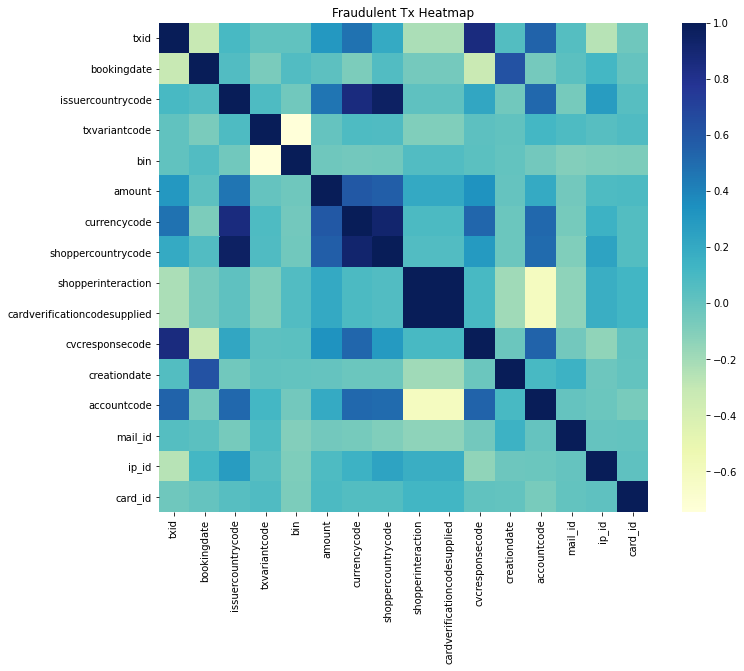

In [39]:
fig, (ax1) = plt.subplots(1, figsize=(12,9))

fraud = df.iloc[np.where(df.simple_journal == 0)].drop('simple_journal', axis=1, inplace=False).corr()
sns.heatmap(fraud, square=True, ax=ax1, cmap = 'YlGnBu')
ax1.set_title('Fraudulent Tx Heatmap')

plt.show()

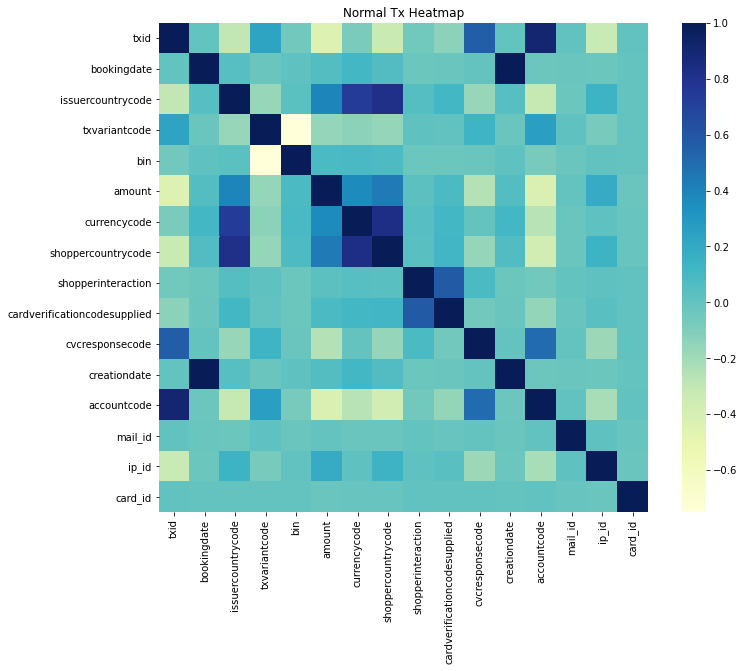

In [40]:
fig, ax2 = plt.subplots(1, figsize=(12, 9))
normal = df.iloc[np.where(df.simple_journal == 1)].drop('simple_journal', axis=1, inplace=False).corr()
sns.heatmap(normal, square=True, ax=ax2, cmap = 'YlGnBu')
ax2.set_title('Normal Tx Heatmap')

plt.show()

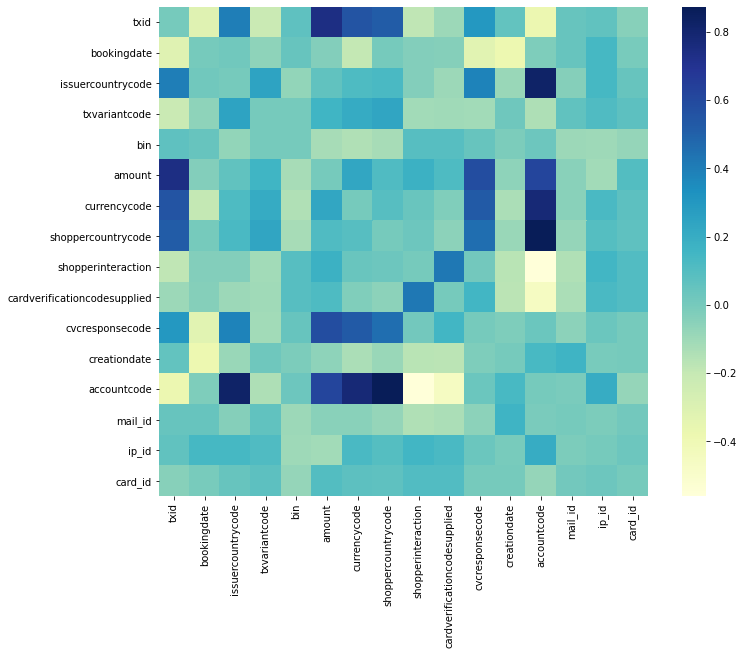

In [41]:
# Let's look at the difference between the fraud data and the normal data, to see if any attributes stand out
# Does this show us anything useful?

fig, (ax1) = plt.subplots(1, figsize=(12, 9))
sns.heatmap(fraud - normal, square=True, ax=ax1, cmap = 'YlGnBu')

plt.show()

In [42]:
### Principal Component Analysis
# Let's take a look at some of the principal components, as it seems that a small number of 
# attributes have high correlation with each other w.r.t. fraudulent activity.

# Let's start with a basic 2-dimensional reduction. First, we need to scale the attributes:


x = df.drop('simple_journal', axis=1, inplace=False)  # Data
x.drop('bookingdate', axis=1, inplace=True)  # Drop to prevent data leaks
# x.drop('txid', axis=1, inplace=True) # Somehow overfitting, gonna try PCA without txid
y = df.simple_journal.copy()   # Target

x = pd.DataFrame(Normalizer().fit_transform(x), columns = x.columns)

In [46]:
# Set the number of components = 2, and fit/transform the data
principal_comp_2 = PCA(n_components=2).fit_transform(x)

# Define the columns
pca_2 = pd.DataFrame(principal_comp_2, columns = ['PC_1', 'PC_2'])

# Add the target labels back in so we can use them for plotting
pca_2 = pd.concat([pca_2, y], axis=1)

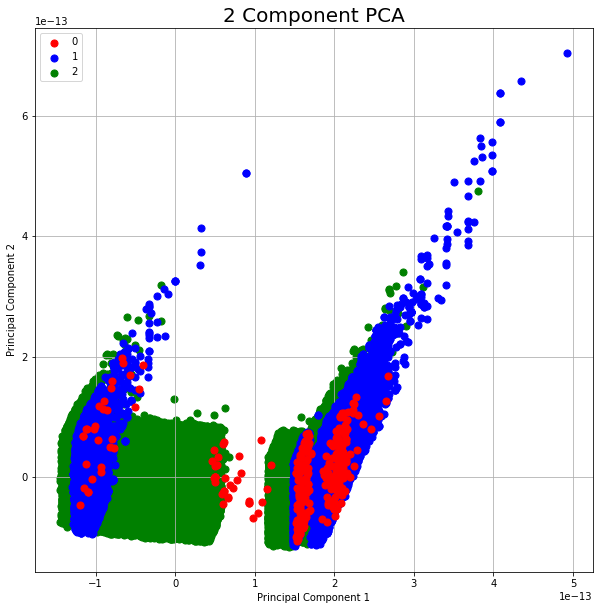

In [44]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2 Component PCA', fontsize = 20)

# Define the targets. 0 = fraud, 1 = possible fraud, 2 = benign
targets = [0,1,2]

# Zorder is just the layering on the scatterchart. I exaggerated the values to ensure the fraud was on top (weird behavior with plt.scatter)
zorder = [50,10,1]

colors = ['r', 'b', 'g']


for target, color, z in zip(targets, colors, zorder):
    indicesToKeep = pca_2['simple_journal'] == target   # Define which indices to preserve for each category
    ax.scatter(pca_2.loc[indicesToKeep, 'PC_1'], pca_2.loc[indicesToKeep, 'PC_2'], c = color, s = 50, zorder=z)


ax.legend(targets)
ax.grid()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

Our visualizations focused primarily on feature correlation and principal component analysis. The correlation heat maps suggest that aside from a few specific features, there is a high level of variance and diversity in the dataset such that most features are relatively decoupled. With respect to the features that are highly correlated, the transaction amount in fraudulent cases was highly correlated with the type of webshop, and the location of the shopper (country and currency). 

When conducting principal component analysis, we decided to keep confirmed cases of fraud separate from potential cases of fraud, as the difference was worth investigating. In an analysis of two principal components, it is clear that cases of confirmed fraud are firmly overlapping the benign transactions. The majority of "outliers" in this case are actually the "refused" class, and not the confirmed fraud cases. If one looks closely, one can see that the minority class (confirmed fraud) is highly clustered around two specific points. However, these clusters are firmly overlapping the majority class, and therefore it is not possible to use PCA or dimensionality reduction as a means to build a discriminator.

That being said, principal component analysis is also finnicky and difficult to fine-tune. In this assignment, the data is scaled and centered, but it could be that the high correlation between two or more features that are also highly correlated to the fraud label are obscured by other features that are reduced during PCA.

To summarize:

    - A few features in particular are 'decoupled' from the rest of the dataset, in terms of correlation. (Amount, currencycode, and shopper country code)
    - The minority class oftentimes firmly overlaps the majority class(es).
    - Principal component analysis shows that only a few outliers of the positive target class are easily discernable from the rest. 

## 2. Imbalance task (SMOTE) – 1 A4 – Individual

#### Individual task of Srinath Jayaraman

### 2a. Print ROC curves

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

### 2c. Is using SMOTE a good idea? Why (not)?

## 3. Privacy task (Rank Swap) – 1 A4 – Individual

### 3a. Print ROC curves

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

## 4. Classification task – 2 A4


We combine the benign and "maybe fraud" cases. We could also drop the "maybe fraud", but this means that potentially valuable information is lost, and we decided to treat it as "benign" due to the fact that we want to reduce the impact that false positives have on our classifier. Since false positives are expensive, we wanted to minimize them as much as possible.

In [19]:
# Redefine the datasets to reset everything after individual sections

df_X = df.drop('simple_journal', axis=1, inplace=False)
df_X.drop('bookingdate', axis=1, inplace=True) # Drop timestamp to prevent potential overfitting
df_X.drop('txid', axis=1, inplace=True) # chargebacks are grouped by txid
df_Y = df.simple_journal



df_Y.loc[np.where(df_Y == 2)] = 1 # Combine the benign and "maybe fraud" values
df_Y.loc[np.where(df_Y == 0)] = 3 # Set the fraud values to 3 temporarily
df_Y.loc[np.where(df_Y == 1)] = 0 # Set the benign values = 0
df_Y.loc[np.where(df_Y == 3)] = 1 # Set the fraud target value = 1

# Small dataset for faster hyperparameter CV tuning
df_X_small, df_Y_small = df_X.iloc[:10000], df_Y.iloc[:10000]

# Create the SMOTE data (*** USING SMOTE LIBRARY UNTIL PERSONAL IMPLEMENTATION IS FINISHED ***)
df_X_smote, df_Y_smote = SMOTE(0.5).fit_resample(df_X, df_Y)
# Small dataset for SMOTE data as well
df_X_small_smote, df_Y_small_smote = df_X_smote.iloc[:10000], df_Y_smote.iloc[:10000]


strat_kfold = StratifiedKFold(n_splits=10, shuffle=True) # stratified K-fold will help prevent the minority class from being drowned out

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [20]:
### --- Unswapped, unsmote data
for train_index, test_index in strat_kfold.split(df_X, df_Y):
    x_train, x_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = df_Y.iloc[train_index], df_Y.iloc[test_index]
    
# the black box model needs to have scaled inputs
x_train_black = pd.DataFrame(RobustScaler().fit_transform(x_train), columns=x_train.columns)
x_test_black = pd.DataFrame(RobustScaler().fit_transform(x_test), columns=x_test.columns)

# the white box model (trees/forests) generally don't need scaled inputs
x_train_white = pd.DataFrame(x_train, columns=x_train.columns)
x_test_white = pd.DataFrame(x_test, columns=x_test.columns)   
    


In [21]:
### --- Smote, unswapped data
for train_index, test_index in strat_kfold.split(df_X_smote, df_Y_smote):
    x_train_smote, x_test_smote = df_X_smote.iloc[train_index], df_X_smote.iloc[test_index]
    y_train_smote, y_test_smote = df_Y_smote.iloc[train_index], df_Y_smote.iloc[test_index]
    
x_train_black_smote = pd.DataFrame(RobustScaler().fit_transform(x_train_smote), columns=x_train_smote.columns)
x_test_black_smote = pd.DataFrame(RobustScaler().fit_transform(x_test_smote), columns=x_test_smote.columns)

x_train_white_smote = pd.DataFrame(x_train_smote, columns=x_train_smote.columns)
x_test_white_smote = pd.DataFrame(x_test_smote, columns=x_test_smote.columns)   
    


### Black box model: MLP

In [22]:
MLP = MLPClassifier(hidden_layer_sizes=10, solver='sgd', max_iter=1000)

params = {'hidden_layer_sizes':[10, 25, 50, 100],
          'solver':('lbfgs','sgd','adam'),
          'alpha':[0.0001, 0.001, 0.01],
          'learning_rate':('constant', 'adaptive')
         }

grid = GridSearchCV(MLP, params, cv=10, n_jobs=-1, verbose=2)

# use the small dataset to speed up the grid search
%time grid.fit(df_X_small, df_Y_small)
grid.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Wall time: 2min 8s


GridSearchCV(cv=10,
             estimator=MLPClassifier(hidden_layer_sizes=10, max_iter=1000,
                                     solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [10, 25, 50, 100],
                         'learning_rate': ('constant', 'adaptive'),
                         'solver': ('lbfgs', 'sgd', 'adam')},
             verbose=2)

In [23]:
MLP_smote = MLPClassifier(hidden_layer_sizes=10, solver='sgd', max_iter=1000)

params_smote = {'hidden_layer_sizes':[10, 25, 50, 100],
          'solver':('lbfgs','sgd','adam'),
          'alpha':[0.0001, 0.001, 0.01],
          'learning_rate':('constant', 'adaptive')
         }

grid_smote = GridSearchCV(MLP_smote, params_smote, cv=10, n_jobs=-1, verbose=2)

# use the small dataset to speed up the grid search
%time grid_smote.fit(df_X_small_smote, df_Y_small_smote)
grid_smote.best_params_

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Wall time: 1min 1s


GridSearchCV(cv=10,
             estimator=MLPClassifier(hidden_layer_sizes=10, max_iter=1000,
                                     solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [10, 25, 50, 100],
                         'learning_rate': ('constant', 'adaptive'),
                         'solver': ('lbfgs', 'sgd', 'adam')},
             verbose=2)

In [26]:
MLP = MLPClassifier(alpha=0.0001, hidden_layer_sizes=10, learning_rate='constant', solver='sgd', verbose=2)

%time MLP.fit(x_train_black, y_train)

# Check the model's performance:
# Precision:
# Recall:
# F1 score (TP / (TP + 0.5(FP+FN)))
# Support:


print('MLP model precision: ', precision_recall_fscore_support(y_test, MLP.predict(x_test_black), average='binary', pos_label=1, zero_division=0)[0])
print('MLP model recall: ', precision_recall_fscore_support(y_test, MLP.predict(x_test_black), average='binary', pos_label=1, zero_division=0)[1])
print('MLP model f1 score: ', precision_recall_fscore_support(y_test, MLP.predict(x_test_black), average='binary', pos_label=1, zero_division=0)[2])
print('MLP model support: ', precision_recall_fscore_support(y_test, MLP.predict(x_test_black), average='binary', pos_label=1, zero_division=0)[3])

Iteration 1, loss = 0.11517926
Iteration 2, loss = 0.02619098
Iteration 3, loss = 0.01759018
Iteration 4, loss = 0.01412340
Iteration 5, loss = 0.01240281
Iteration 6, loss = 0.01126754
Iteration 7, loss = 0.01048990
Iteration 8, loss = 0.00995033
Iteration 9, loss = 0.00957457
Iteration 10, loss = 0.00930939
Iteration 11, loss = 0.00909982
Iteration 12, loss = 0.00896185
Iteration 13, loss = 0.00880874
Iteration 14, loss = 0.00875299
Iteration 15, loss = 0.00863756
Iteration 16, loss = 0.00855469
Iteration 17, loss = 0.00847713
Iteration 18, loss = 0.00841101
Iteration 19, loss = 0.00833446
Iteration 20, loss = 0.00833281
Iteration 21, loss = 0.00826941
Iteration 22, loss = 0.00823577
Iteration 23, loss = 0.00822014
Iteration 24, loss = 0.00823994
Iteration 25, loss = 0.00816886
Iteration 26, loss = 0.00810015
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Wall time: 16.3 s
MLP model precision:  0.0
MLP model recall:  0.0
MLP model f1 score: 

In [27]:
MLP_smote = MLPClassifier(alpha=0.0001, hidden_layer_sizes=(10,), learning_rate='constant', solver='sgd', verbose=2)
%time MLP_smote.fit(x_train_black_smote, y_train_smote)


print('MLP SMOTE model precision: ', precision_recall_fscore_support(y_test_smote, MLP_smote.predict(x_test_black_smote), average='binary', pos_label=1, zero_division=0)[0])
print('MLP SMOTE model recall: ', precision_recall_fscore_support(y_test_smote, MLP_smote.predict(x_test_black_smote), average='binary', pos_label=1, zero_division=0)[1])
print('MLP SMOTE model f1 score: ', precision_recall_fscore_support(y_test_smote, MLP_smote.predict(x_test_black_smote), average='binary', pos_label=1, zero_division=0)[2])
print('MLP SMOTE model support: ', precision_recall_fscore_support(y_test_smote, MLP_smote.predict(x_test_black_smote), average='binary', pos_label=1, zero_division=0)[3])

Iteration 1, loss = 0.36347906
Iteration 2, loss = 0.27796211
Iteration 3, loss = 0.26063820
Iteration 4, loss = 0.24999419
Iteration 5, loss = 0.24186345
Iteration 6, loss = 0.23542797
Iteration 7, loss = 0.23035379
Iteration 8, loss = 0.22618569
Iteration 9, loss = 0.22272418
Iteration 10, loss = 0.21984472
Iteration 11, loss = 0.21742038
Iteration 12, loss = 0.21530905
Iteration 13, loss = 0.21343429
Iteration 14, loss = 0.21174133
Iteration 15, loss = 0.21017305
Iteration 16, loss = 0.20867100
Iteration 17, loss = 0.20719992
Iteration 18, loss = 0.20581069
Iteration 19, loss = 0.20447052
Iteration 20, loss = 0.20317800
Iteration 21, loss = 0.20192404
Iteration 22, loss = 0.20066296
Iteration 23, loss = 0.19941738
Iteration 24, loss = 0.19814371
Iteration 25, loss = 0.19694119
Iteration 26, loss = 0.19567165
Iteration 27, loss = 0.19440880
Iteration 28, loss = 0.19313375
Iteration 29, loss = 0.19206568
Iteration 30, loss = 0.19111260
Iteration 31, loss = 0.19017435
Iteration 32, los

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### White box model: Random Forest

In [28]:
forest = RandomForestClassifier()

forest_params = {'n_estimators':[100, 250, 500, 1000],
                 'criterion':('gini', 'entropy'),
                 'class_weight':['balanced'],
                 'max_features':('sqrt', 'log2')
                }
grid_forest = GridSearchCV(forest, forest_params, cv=10, n_jobs=-1, verbose=2)
%time grid_forest.fit(df_X_small, df_Y_small)
grid_forest.best_params_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Wall time: 1min 6s


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ('gini', 'entropy'),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': [100, 250, 500, 1000]},
             verbose=2)

In [68]:
forest = RandomForestClassifier(class_weight='balanced', criterion='gini', max_features='sqrt', n_estimators=100)
%time forest.fit(x_train_white, y_train)

print('Forest model precision: ', precision_recall_fscore_support(y_test, forest.predict(x_test_white), average='binary', pos_label=1, zero_division=0)[0])
print('Forest model recall: ', precision_recall_fscore_support(y_test, forest.predict(x_test_white), average='binary', pos_label=1, zero_division=0)[1])
print('Forest model f1 score: ', precision_recall_fscore_support(y_test, forest.predict(x_test_white), average='binary', pos_label=1, zero_division=0)[2])
print('Forest model support: ', precision_recall_fscore_support(y_test, forest.predict(x_test_white), average='binary', pos_label=1, zero_division=0)[3])

Wall time: 26.1 s
Forest model precision:  1.0
Forest model recall:  0.058823529411764705
Forest model f1 score:  0.1111111111111111
Forest model support:  None


In [31]:
### --- Random Forest on SMOTE data --- ###

forest_smote = RandomForestClassifier()

forest_smote_params = {'n_estimators':[100, 250, 500, 1000],
                 'criterion':('gini', 'entropy'),
                 'class_weight':['balanced'],
                 'max_features':('sqrt', 'log2')
                }
grid_forest_smote = GridSearchCV(forest_smote, forest_smote_params, cv=10, n_jobs=-1, verbose=2)
%time grid_forest_smote.fit(df_X_small_smote, df_Y_small_smote)
grid_forest_smote.best_params_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Wall time: 1min 6s


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ('gini', 'entropy'),
                         'max_features': ('sqrt', 'log2'),
                         'n_estimators': [100, 250, 500, 1000]},
             verbose=2)

In [69]:
forest_smote = RandomForestClassifier(class_weight='balanced', criterion='gini', max_features='log2', n_estimators=100)
%time forest_smote.fit(x_train_white_smote, y_train_smote)

print('Forest model precision: ', precision_recall_fscore_support(y_test_smote, forest_smote.predict(x_test_white_smote), average='binary', pos_label=1, zero_division=0)[0])
print('Forest model recall: ', precision_recall_fscore_support(y_test_smote, forest_smote.predict(x_test_white_smote), average='binary', pos_label=1, zero_division=0)[1])
print('Forest model f1 score: ', precision_recall_fscore_support(y_test_smote, forest_smote.predict(x_test_white_smote), average='binary', pos_label=1, zero_division=0)[2])
print('Forest model support: ', precision_recall_fscore_support(y_test_smote, forest_smote.predict(x_test_white_smote), average='binary', pos_label=1, zero_division=0)[3])

Wall time: 1min 10s
Forest model precision:  0.9982775251481328
Forest model recall:  0.9991724708640783
Forest model f1 score:  0.9987247975185249
Forest model support:  None


In [40]:
print(x_train_white.shape)
print(x_train_smote.shape)

(261344, 14)
(391550, 14)


### 4a. Print relevant plots and metrics with clear headings.

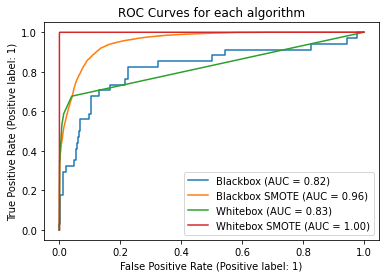

In [70]:
ax = plt.gca()

rfc_disp = plot_roc_curve(MLP, x_test_black, y_test, ax=ax, name='Blackbox')
rfc_disp = plot_roc_curve(MLP_smote, x_test_black_smote, y_test_smote, ax=ax, name='Blackbox SMOTE')

rfc_disp = plot_roc_curve(forest, x_test_white, y_test, ax=ax, name='Whitebox')
rfc_disp = plot_roc_curve(forest_smote, x_test_white_smote, y_test_smote, ax=ax, name='Whitebox SMOTE')

ax.set_title("ROC Curves for each algorithm")

plt.show()

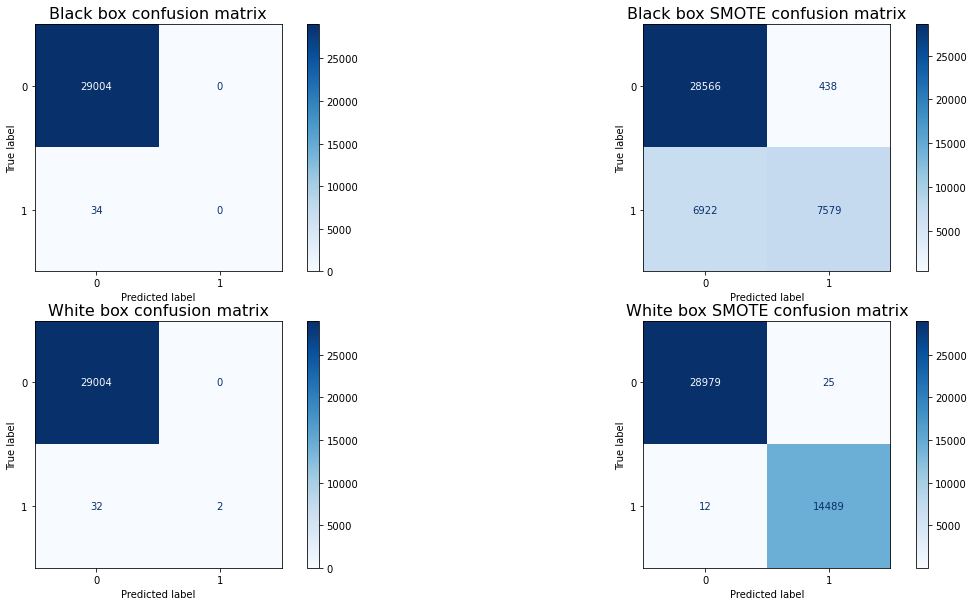

In [71]:
from sklearn.metrics import plot_confusion_matrix

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize =(20, 10))

disp = plot_confusion_matrix(MLP, x_test_black, y_test, cmap=plt.cm.Blues, ax=ax1)
disp.ax_.set_title("Black box confusion matrix", fontsize=16)

disp = plot_confusion_matrix(MLP_smote, x_test_black_smote, y_test_smote, cmap=plt.cm.Blues, ax=ax2)
disp.ax_.set_title("Black box SMOTE confusion matrix", fontsize=16)






disp = plot_confusion_matrix(forest, x_test_white, y_test, cmap=plt.cm.Blues, ax=ax3)
disp.ax_.set_title("White box confusion matrix", fontsize=16)


disp = plot_confusion_matrix(forest_smote, x_test_white_smote, y_test_smote, cmap=plt.cm.Blues, ax=ax4)
disp.ax_.set_title("White box SMOTE confusion matrix", fontsize=16)

plt.show()

In [36]:
# Let's use shap to visualize the random forest a bit
import shap
forest_explainer = shap.TreeExplainer(forest)

# We can look at the explanation for a specific example...
shap_values = forest_explainer.shap_values(x_test_white.iloc[50])
shap.initjs()
shap.force_plot(forest_explainer.expected_value[1], shap_values[1], x_test_white.iloc[50])

In [72]:
forest_smote_explainer = shap.TreeExplainer(forest_smote)

# We can look at the explanation for a specific example...
shap_smote_values = forest_smote_explainer.shap_values(x_test_white_smote.iloc[50])
shap.initjs()
shap.force_plot(forest_smote_explainer.expected_value[1], shap_smote_values[1], x_test_white_smote.iloc[50])

In [ ]:
# # ... or we can take a look at the summary plot for all attributes/examples

# ### !!! CAREFUL - this takes an extremely long time!
# shap_values = forest_explainer.shap_values(x_test_white)
# %time shap.summary_plot(shap_values[1], x_test_white)

In [ ]:
# # ... or we can take a look at the summary plot for all attributes/examples

# ### !!! CAREFUL - this takes an extremely long time!
# shap_smote_values = forest_explainer.shap_values(x_test_white_smote)
# %time shap.summary_plot(shap_values[1], x_test_white_smote)

### 4b. Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

We wanted to compare the efficacy of not just a black vs white box method, but also the effect that SMOTE had on each of these models. Therefore, there are four models trained above. We applied the following methods, in order:

### Pre-processing
1. Drop the 'bookingdate' and 'txid' attributes. Chargebacks are grouped by 'txid', and 'bookingdate' has hindsight. 
    - We noticed that 'txid' dramatically affected the performance of our models, leaking tons of information about the target labels, so we dropped it entirely.
2. Combine the "maybe fraud" and "benign" attributes, as we want to minimize false positives (lecture theory indicated that FP is an expensive event to handle)
3. Define our datasets:
    - Normal, SMOTE, and "small" dataset (for faster cross-validation)
4. Apply stratified 10-fold CV to maintain minority class distribution in training/testing sets.
5. Create separate datasets for black/white box models.
    - Create a SMOTE version of each of these
6. Do a 10-fold CV Grid Search for the black and white box models, on both normal and SMOTE datasets.
    - Apply hyperparameter tuning results to these models
7. Train and test the models

---
### Models
1. **Black Box**: Multi-layer perceptron, a basic neural network, was applied as explainability is low.
    - Multi-layer perceptrons are a very basic form of neural network, which take an input of fixed size (the number of attributes) and optimize using gradient descent to make either a binary classification, or linear prediction.
2. **White Box**: Random forest, an ensemble method, was applied as it has very high explainability.
    - A random forest is a "forest" of decision trees, all of which are trained and then the ensemble method outputs the most common result between the trees (mode) as a classification prediction.
    
---
### Efficacy

**Black Box:** The MLP performed extremely poorly on the unsmote data, almost certainly due to class imbalance. Neural networks in relatively default settings often perform extremely poorly on imbalanced data, especially if the positive target class doesn't contain extreme outliers. The plain MLP had a precision and recall of 0.0, meaning it missed all of the fraud data and was essentially useless.
    - SMOTE data on the MLP increased performance dramatically. The TPR (TP / (TP+FN)) was about **52.9%**, not exactly a great percentage, but the FPR was a mere **1.8%**, a respectable number considering the high class imbalance.
    
**White Box:** The forest performed better than the MLP with normal and SMOTE data, but between the two white-box models was a great discrepancy. Class imbalance played a huge factor. 
    - The white box model performed quite poorly on the normal data, only correctly identifying two cases of fraud.
        - TPR = 5.9%
        - FPR = 0.0%
    - However, on the SMOTE data, the white box model performed extremely well:
        - TPR = 99.9%
        - FPR = 0.086%

The White Box SMOTE model has an AUC = 1.0, however this is likely an effect of rounding, as it did not perform "perfectly" on the data, and is likely rounded up from .999. That being said, such an efficacy would warrant double-checking of the data pipeline to ensure there are no leaks. During this assignment, we repeatedly restarted the kernel and triple-checked our datasets to try to identify any leaks but we were unable to find anything, leading us to believe that the white-box SMOTE model is indeed robust.

It is clear that oversampling the minority class has a dramatic effect on the classifier, in both models. If we look at the two **shap** plots above, we can see that the attributes that had the most effect on the classification model vary, depending on if the data is oversampled. However, `accountcode` - the variable related to the merchant's webshop - had the most outsized effect when taking both models into consideration. This shows that the specific webshop a fraudulent transaction occurred at was important in determining a fraudulent transaction, which could be explained by certain fraudsters attempting to purchase specific, high-ticket items with somebody else's credit card.

## 5. Bonus task – 1 A4


### 5a. Provide code and report below

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad0f8f88-574f-4936-aedb-0b72571d8308' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>